# manipulating Image Data in python

This code will show you how to work with image data for common image processing tasks like brightening, dimming, blurring, and converting to a Pandas Dataframe. These snippets should help you understand the process of image manipulation as well as give you some tools to enhance your own image processing skills.

The firsat task is simply to load the image. I have included a color PNG image of a bird I wil be using for this example.

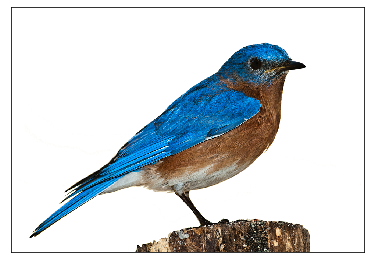

In [1]:
import numpy as np
import pandas as pd
from skimage.io import imread, imshow
from matplotlib import pyplot as plt
from skimage import morphology
%matplotlib inline

img_file = "bird.png"
img = imread(img_file)
oax = imshow(img)
plt.ylabel("")
plt.xlabel("")
plt.xticks([])
plt.yticks([])
plt.show()

To understand the image structure you can view the shape of the data

In [2]:
img.shape

(668, 960, 4)

This shows that the image is 668 pixels high, 960 pixels wide, and has 4 channels. You can separate the image into it's constituent layers to manipulate each individually like so

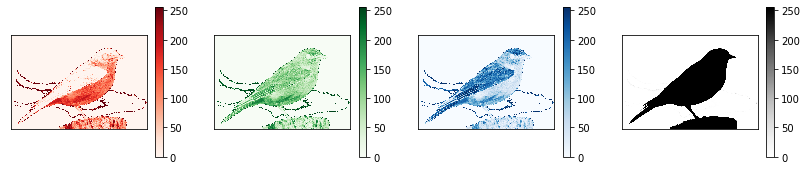

In [3]:
r, g, b, a = img[:, :, 0], img[:, :, 1], img[:, :, 2], img[:, :, 3] # Extract channels
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(14,11))
ims = [
    ax[0].imshow(r, cmap="Reds"),
    ax[1].imshow(g, cmap="Greens"),
    ax[2].imshow(b, cmap="Blues"),
    ax[3].imshow(a, cmap="Greys")
]
cbars = []
for i in range(len(ims)):
    im = ims[i]
    axi = ax[i]
    cbars.append(fig.colorbar(im, ax=axi, shrink=0.25))

for i in range(len(ax)):
    ax[i].set_ylabel("")
    ax[i].set_xlabel("")
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()

Many stegonography programs use a technique called <span style="fontcolor:#0000FF">Least Significant Bit shifting (LSB shift)</span>, which can be seen as changes to the value in the blue data channel of the image. Using the above separation would allow a researcher to  You can also take the average of all the channels with a single command.

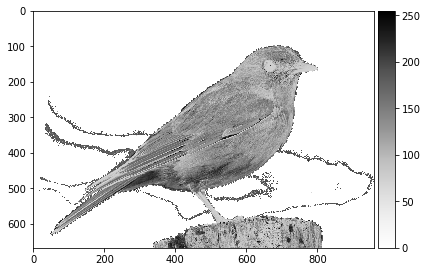

In [13]:
feature_matrix = img.mean(axis=2)
imshow(feature_matrix, cmap="Greys")
plt.show()

You can also see the alpha channel is masking everything but the bird's outline. You can repack the image without any given channel (in this example the alpha)

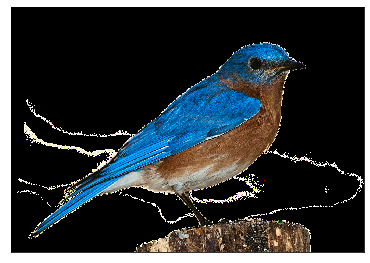

In [14]:
unmasked = np.dstack((r, g, b))  # stacks arrays -> h x w x 3
imshow(unmasked)
plt.ylabel("")
plt.xlabel("")
plt.xticks([])
plt.yticks([])
plt.show()

You can use the morphology library to mathematically alter the image in 2D or 3D depending on your needs. If you want to work on each color channel individually you can use 2D shapes that only consider pixel values in the same channel. This code will use a diamond shape to dilate (highlight and spread) on the green channel, while eroding (darkening and shrinking) on the blue channel. 

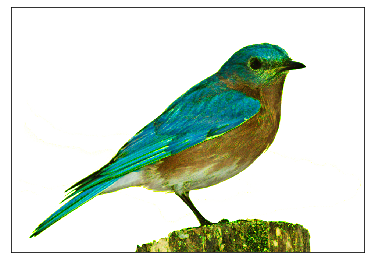

In [16]:
g_morph = morphology.dilation(
        g, morphology.diamond(1)
    ) # Highlight and spread the green channel
b_morph = morphology.erosion(
        b, morphology.diamond(2)
    ) # Darken the blue channel by shrinking bright areas
feature_morph = np.dstack((r,g_morph,b_morph,a))  # stacks arrays -> h x w x 4
#ax[0] = imshow(img)
imshow(feature_morph)
plt.ylabel("")
plt.xlabel("")
plt.xticks([])
plt.yticks([])
plt.show()

When you are working on all the channels of the image you will want to use 3D shapes like an octahedron (3D equivalent of a diamond)This allows the pixel values in one channel to consider the value of neighboring pixels in other channels as well. 

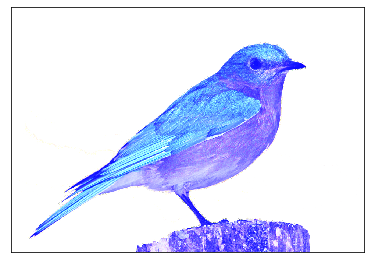

In [15]:
feature_morph = morphology.dilation(
        img, morphology.octahedron(1)
    )
imshow(feature_morph)
plt.ylabel("")
plt.xlabel("")
plt.xticks([])
plt.yticks([])
plt.show()

I as I mentioned previously, you can also encode information into the pixel data of images using some method of stegonagraphy. There are several different methods of encoding the information into the pixels but they all share the goal of not alterring the pictures visual characteristics in any way detectible to the human eye. Ideally, your stegonagraphy algorithm will not change to many values in any one location of the image, as this will introduce noticeable artifacts. The method mentione previous ,LSB shifting, makes alterations to the pixel values of the blue channel (since this is the color which occupies the least significant 8 bits of a 32 bit color code. The following snippet will encode the string "hide me!" skipping 14 pixels between letter placements.

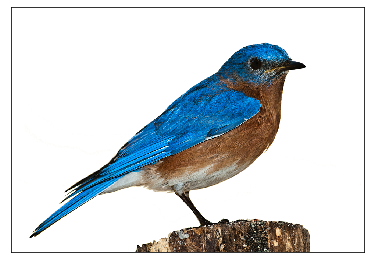

In [30]:
b_string = [ord(c) for c in "hide me!"]
str_len = len(b_string) 
skip_sz = 10
b_copy = np.copy(b)
r_copy = np.copy(r)
r_copy[0][0] = str_len # Encode the length in the first byte of the red channel
for i in range(len(b_string)):
    # write the data, skipping the number of pixels
    b_copy[i+(i*skip_sz)][14] = b_string[i]
hidden_img = np.dstack((r_copy,g,b_copy,a))  # stacks arrays -> h x w x 4
imshow(hidden_img) 
plt.ylabel("")
plt.xlabel("")
plt.xticks([])
plt.yticks([])
plt.show()

Even though the data has been inserted the image remains visibly unchanged. There is a limit to how much data can be encoded this way without interfering with the image and leaving visual artifacts. You can recover the data using the reverse process

In [35]:
unst_r, unst_g, unst_b, unst_a = hidden_img[:, :, 0], hidden_img[:, :, 1], hidden_img[:, :, 2], hidden_img[:, :, 3]
u_string = []
skip_sz = 10
rec_len = unst_r[0][0]
print("Character count: %d" % rec_len)
for i in range(rec_len):
    u_string.append(chr(unst_b[i+(i*skip_sz)][14]))
print("Recovered: " + "".join(u_string))

Character count: 8
Recovered: hide me!


When you are working to analyze image sets you will need to decide on a method to represent the data. One common way is to average the channels (after any desired normalization is applied) and then 'unravel' the image by turning it into an n*m length vector. You can do this with the reshape function.

In [17]:
num_pix = (feature_morph.shape[0]*feature_morph.shape[1])
# Flatten the mean image matrix
features = pd.Series(list(np.reshape(feature_matrix, num_pix)))
df = pd.DataFrame(features)
df = df.transpose()
df

,0,1,2,3,4,5,6,7,8,9,...,641270,641271,641272,641273,641274,641275,641276,641277,641278,641279
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
